# Time Series Handson
- time dependant data : perform time series forecasting
- forecasting for future values

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Reading the dataset

In [65]:
df_airline = pd.read_csv('airline_passengers.csv')
df_airline.head()

,Month,Thousands of Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


### Analysis of data

In [66]:
df_airline.shape

(145, 2)

In [67]:
df_airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    145 non-null    object 
 1   Thousands of Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [68]:
# drop null columns
df_airline.dropna(axis = 0,inplace = True)

### Formating data 
> converting month to datetime format

> change Month as index of the data

In [69]:
df_airline['Month'] = pd.to_datetime(df_airline['Month']) # convert Month to datetime
df_airline.set_index('Month',inplace = True)              # update the index as Month

In [70]:
df_airline.head()

,Thousands of Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


<Axes: xlabel='Month'>

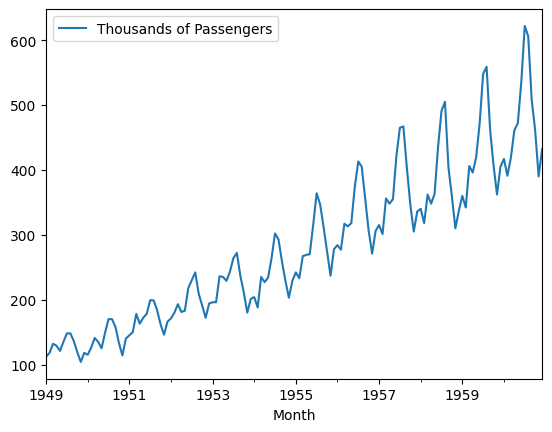

In [71]:
df_airline.plot()

### Stationarity Check
- 1). rolling mean and rolling stand dev

- 2). adf test(hypothesis tests)

**1. Rolling mean and rolling std dev**

In [72]:
mean_roll = df_airline.rolling(window = 12).mean() 
std_roll = df_airline.rolling(window = 12).std()
# window 12 : data is repeated itself after 12months ( 1year or seasonality) 

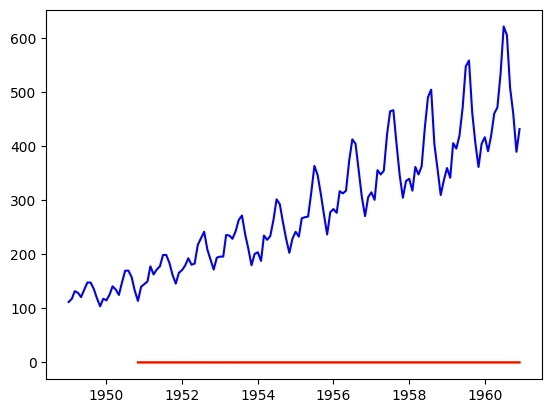

In [85]:
plt.plot(df_airline, color = 'Blue')
plt.plot(mean_roll, color = 'Orange')
plt.plot(std_roll, color = 'red')

if the rolling mean and std dev are constant or parallel with time (x-axis),we'll say that the data is stationary

From the above graph , mean_roll and std_roll are not constant with time thus the data is not stationary

***2. Augumented Dickey Fuller Test***
Null Hypothesis : Series is non-stationary
Alternate Hypothesis : Series is Stationary
    
- if p value <= 0.05 ***Reject Null Hpythesis***,meaning it is stationary
- if p value > 0.05 ***fail to reject Null Hpythesis***, says that it is not stationary

In [86]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_airline['Thousands of Passengers'])
print(result[1]) # print(pvalue)

0.9918802434376409


pvalue is 0.9918802434376409
p value > 0.05 fail to reject Null Hpythesis, says that it is not stationary

### Convert Data To Stationary Data

Step :1 Log Transformation : smoothing of the curve by scaling down the values

In [87]:
df_airline_log_1 = np.log(df_airline)
df_airline_log_1.head()

,Thousands of Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791


Step 2 : Subtracting log transformed values and rolling mean values

In [88]:
mean_log = df_airline_log_1.rolling(window = 12).mean()
new_df = df_airline_log_1-mean_log
new_df.dropna(inplace = True)
new_df.head()

,Thousands of Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


#### Now check if the data is converted to stationary or not

In [89]:
result = adfuller(new_df['Thousands of Passengers'])
print(result[1]) # print(pvalue)

0.02223463000124264


since after transformation, p_value is less than 0.05 --> reject the null hypothesis (series is stationary)

### plot the original data, rolling mean, and rolling standard deviation after making the data stationary

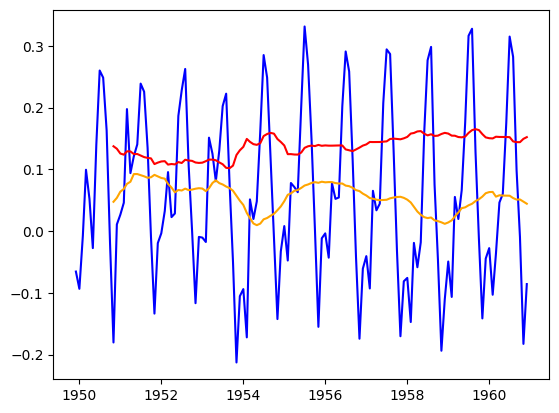

In [90]:
mean_roll = new_df.rolling(window = 12).mean() 
std_roll = new_df.rolling(window = 12).std()
plt.plot(new_df, color = 'Blue')
plt.plot(mean_roll, color = 'Orange')
plt.plot(std_roll, color = 'red')


#### ARIMA

**AR**
Auto regression : if we need to forecast current value, then that current value can be explained by how many previous values
- p : Partial Auto Correlation Factor(AR) : PACF Plot
- if p is 2 , it means for the month of march , we will use previous 2 months data to forecast data for march

**Differencing(I)**
d : 0 (here d value is 0 , Because we have not used differencing. Differencing is used to convert non stationary data into stationary data m=, in case log tranformation i not performing well)
  
**MA**
uses for removal of fluctuations/tends of entire data and then use to make forecast
- q : Auto Correlation Factor(MA) : ACF Plot
- if q is 3, the entire data is divided into three groups and them from these three group fluctuations are removed and used for future forecast

#### Calculating p, q values And PACF , ACF Plots

In [91]:
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

pacf_val = pacf(new_df)
acf_val = acf(new_df)

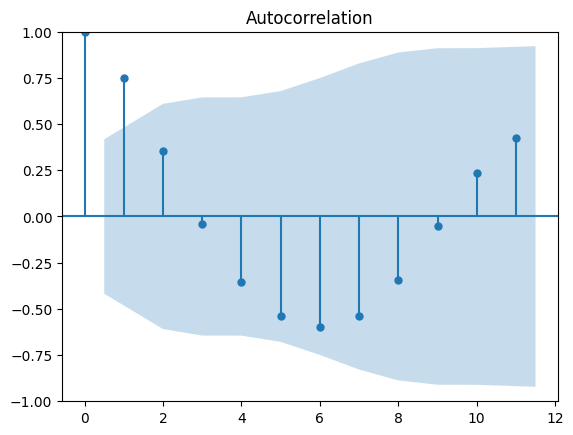

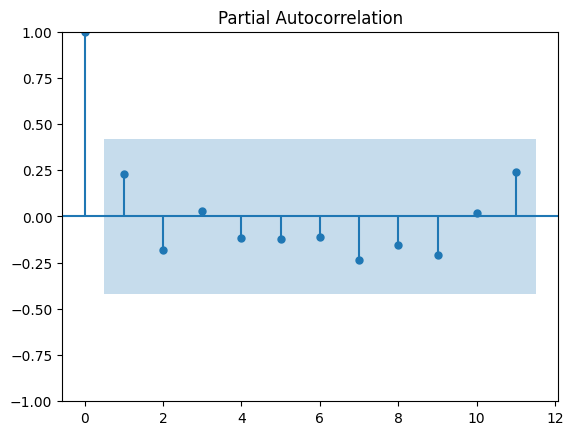

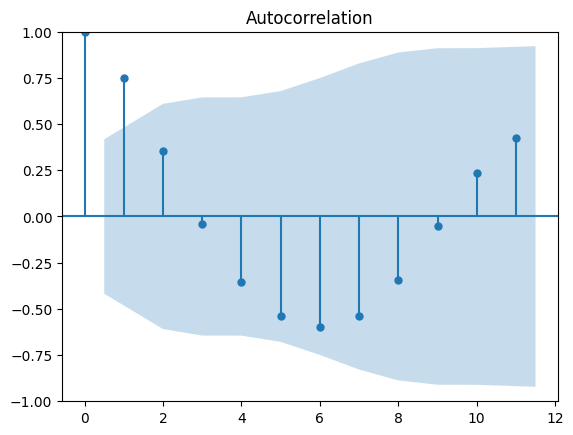

In [92]:
plot_pacf(pacf_val)
plot_acf(acf_val)

#### Summary From Above Plots 
- p : PACF plot: first instance when the data crosses the horizontal line(0 line),take that value as p : 2
- q : ACF plot: first instance when the data crosses the horzontal line(0 line),take that value as q : 3

### Model Building

In [95]:
new_df.shape

(133, 1)

In [102]:
train = new_df.iloc[:120] #training the model on 10 years
test = new_df.iloc[120:]

### ARIMA Model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model_1 = ARIMA(train,order = (2,0,3))
model_1 = model_1.fit()

### Forecasting for next 24 months (2 years) 

In [136]:
forecast = model_1.get_forecast(steps = 24) #forecasting for next 24 months (2 years)
forecast_values = forecast.predicted_mean

<Axes: xlabel='Month'>

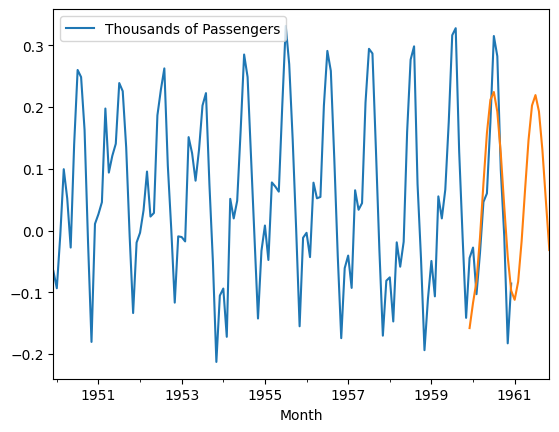

In [137]:
new_df.plot()
forecast_values.plot()

### SARIMA Model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# obj_model = SARIMAX(data, order = (p,d,q),seasonal_order=(p,d,q,s))
model_2 = SARIMAX(train,order = (2,0,3),seasonal_order = (2,0,3,12))
model_2 = model_2.fit()

### forecasting for next 24 months (2 years) 

In [139]:
forecast_2 = model_2.get_forecast(steps = 24) 
forecast_values = forecast_2.predicted_mean

<Axes: xlabel='Month'>

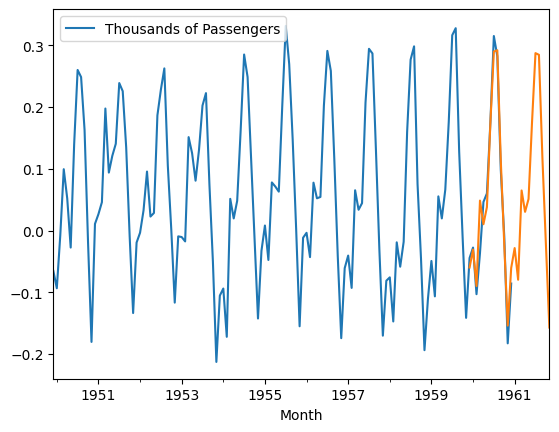

In [140]:
new_df.plot()
forecast_values.plot()

#### forecasting for next 60 months (5 years) 

In [141]:
forecast_3 = model_2.get_forecast(steps = 60) 

In [142]:
forecast_3.predicted_mean.head()

1959-12-01   -0.059805
1960-01-01   -0.030774
1960-02-01   -0.089900
1960-03-01    0.048572
1960-04-01    0.010228
Freq: MS, Name: predicted_mean, dtype: float64

In [143]:
forecast_values = forecast_3.predicted_mean
df_forecast = pd.DataFrame(forecast_values)
concat_df = pd.concat([new_df,df_forecast])

<Axes: >

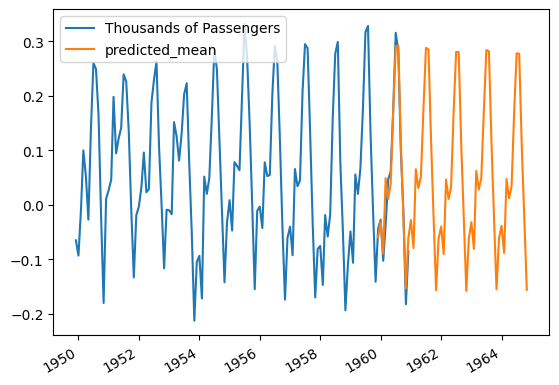

In [144]:
concat_df.plot()